# Notes
* Here are some of the problems you could run into:
  
* You may be faced with the problem of gradients growing ever smaller or larger,
  * when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.
   
*  You might not have enough training data for such a large network, or it might be too costly to label.
*   Training may be extremely slow.
*    A model with millions of parameters would severely risk overfitting the training
     *    set, especially if there are not enough training instances or if they are too noisy.
*    we will look at transfer learning and unsupervised pretraining, which can help you 
     *    tackle complex tasks even when you have little labeled data. 
     *    Using various optimizers that can speed up training large models tremendously.

# Training Deep Neural Networks

* Better initialization
  
* Other Activation functions
* Gradient Clipping
* Better Optimizers
* Transfer Learning , Auxillary output training 
  

# Vanishing / Exploding Gradients problem

* Unfortunately, gradients often get smaller and smaller as the algorithm progresses
  * down to the lower layers. As a result, the gradient descent update leaves the lower
  * layers’ connection weights virtually unchanged, and training never converges to a
  * good solution. This is called the **vanishing gradients problem.**

* due to the above, NN were **abandoned** in the early 2000s
* one of the **suspects** was SIGMOID activaiton funciton and the weight initalization technique used at that time
* that has a normal distribution with a mean of 0 and a standard deviation of 1
* The saturation effect by the sigmoid function is worse and has a mean of 0.5 not 0
  * the **tanh** function has a mean of 0 and behaves slightly better than the sigmoid in DNN

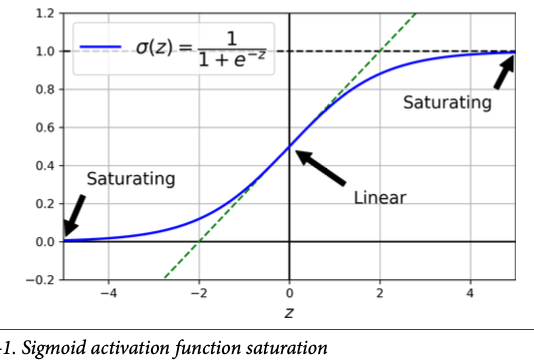

# Glorot & HE initalization

* It is actually not possible to guarantee both unless the layer has an
  * equal number of inputs and outputs (these numbers are called the fan-in and fan-out of the layer)

* where fanavg = (fanIN + fanOUT) /2 
* The initialization strategy proposed for the ReLU activation function and
  *  its variants is called He initialization 
*  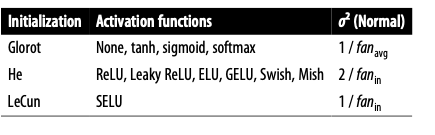
*  Table : initialization parameters for each trype of activation function

In [12]:
import tensorflow as tf 
import warnings
warnings.filterwarnings("ignore")

In [13]:

dense = tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal')

In [14]:
# We can obtain any of the initializations listed in above table and more
# using the variance scaling initializer
# lets do HE initialization, with uniform distribution and fan_avg scaling rather than fan_in

he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                                    distribution='uniform')
dense = tf.keras.layers.Dense(50, activation='sigmoid',
                              kernel_initializer=he_avg_init)
he_avg_init

# Better Activation Functions
## ReLU and Leaky RELU

* **ReLU** activation function is popular, because it does not saturate for positive values
  * and also it is very fast to compute
  
* Unfortunately, the ReLU activation function is not perfect. 
* It suffers from a problem known as the dying ReLUs: during training,
  *  some neurons effectively “die”, meaningthey stop outputting anything other than 0. 
  *  In some cases, you may find that half of your network’s neurons are dead,
  *   especially if you used a **large learning rate**. 
  *   A neuron dies when its weights get tweaked in such a way that the input of the ReLU
  *   function (i.e., the weighted sum of the neuron’s inputs plus its bias term) is negative
  *   for all instances in the training set. When this happens, it just keeps **outputting zeros,**
  *   and gradient descent does not affect it anymore because the gradient of the ReLU
  *   function is zero when its input is negative
*  To solve this problem, you may want to use a variant of the ReLU function, 
   *  such as the **leaky ReLU**
* The leaky ReLU activation function is defined as **LeakyReLU α(z) = max(αz, z)**
  * The hyperparameter α defines how much the function “leaks”: it is
  * the slope of the function for z < 0. Having a slope for z < 0 ensures that leaky
  * ReLUs never die; they can go into a long coma,

* Leaky RELU outperformed the strict ReLU activation function. 
  * In fact, setting α = 0.2 (a huge leak) seemed to result in 
  * better performance than α = 0.01 (a small leak). 
  * The paper also evaluated the **randomized leaky ReLU (RReLU)**,
  *  where α is picked randomly in a given range during training and 
  *  is fixed to an average value during testing.
  *  RReLU also performed fairly well and seemed to act as a regularizer,
  *  reducing the risk of overfitting the training set.
  *  Finally, the paper evaluated the **parametric leaky ReLU (PReLU)**,
  *  where α is authorized to be learned during training:
  *  instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation 
  *  like any other parameter. PReLU was reported to strongly outperform ReLU on large 
  *  image datasets, but on smaller datasets it runs the risk of overfitting the training set.
*  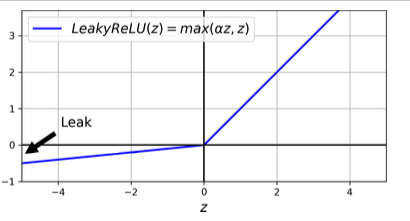

In [17]:
# using leaky relu activation function

leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer='he_normal')
leaky_relu

<LeakyReLU name=leaky_re_lu_6, built=True>

In [16]:
# using leaky relu as a separate layer in the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.2)
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

* ReLU, leaky ReLU, and PReLU all suffer from the fact that they are not smooth
  * functions: their derivatives abruptly change (at z = 0)., 
  * this sort of discontinuity can make gradient descent bounce
  * around the optimum, and slow down convergence. So now we will look at some
  * smooth variants of the ReLU activation function, starting with ELU and SELU.

## ELU and SELU

* ELU
* 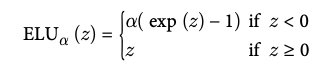
* It takes on negative values when z < 0, which allows the unit to have an
* average output closer to 0 and helps alleviate the vanishing gradients problem.
* The hyperparameter α defines the opposite of the value that the ELU function
* approaches when z is a large negative number. It is usually set to 1, but you cant 
* weak it like any other hyperparameter.
* It has a nonzero gradient for z < 0, which avoids the dead neurons problem.
* If α is equal to 1 then the function is smooth everywhere, including around 
* z =0, which helps speed up gradient descent since it does not bounce as much to the left and right of z = 0.

* Like with other RELU variants, you should use HE Initialization
* Its faster convergence rate during training may compensate for that slow computation,
* but still, at test time an ELU network will be a bit slower than a RELU network

* **scaled ELU(SELU)** activation function: as its name suggests,
*  it is a scaled variant of the ELU activation function (about 1.05 times ELU, using α ≈ 1.67). 
*  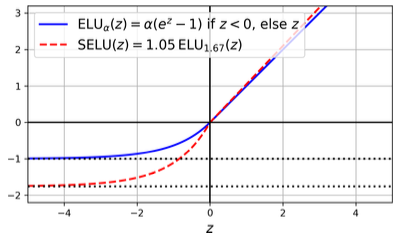

## GELU, Swish, and Mish

* all the activation functions we’ve discussed so far were both convex and monotonic,
  * the GELU activation function is neither: from left to right, it starts by going straight,
  * then it wiggles down, reaches a low point around –0.17 (near z ≈ –0.75), and finally
  * bounces up and ends up going straight toward the top right.
  * In practice, **GELU** often **outperforms** every other activation function discussed
  * so far. However, it is a bit more computationally intensive, and the performance boost
  * it provides is not always sufficient to justify the extra cost
* 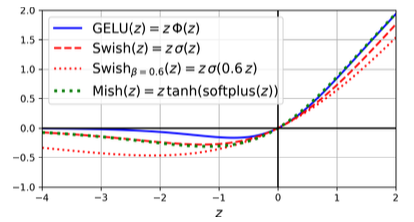

* However, Swish is probably a better default for more complex
  * tasks, and you can even try parametrized Swish with a learnable β
  * parameter for the most complex tasks. 
* **If you care a lot about runtime latency, then you may prefer leaky ReLU, or\
  parametrized leaky ReLU for more complex tasks.**

# Batch Normalization

* Even though with best initialization and activaiton functions
  * it can reduce the vanishing/exploding gradients
  * but it doesnt guarantee that they wont come back during training
* Batch Normalization BN, consists of adding an operation in the model
*  just before or after the activation function of each hidden layer.
*   This operation simply zero-centers and normalizes each input, then
*   scales and shifts the result using two new parameter vectors per layer: one for scaling,
*   the other for shifting. In other words, the operation lets the model learn the optimal
*   scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer
*   as the very first layer of your neural network, you do not need to standardize your training set.

* The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the tanh and even the sigmoid activation function. 
* The networks were also much less sensitive to the weight initialization.
* You can use much larger learning rates, significantly speeding up the learning process
* **Batch Normalizaiton acts like a regularizer**

## Implementing batch Normalization with keras

In [18]:
## Batch Normalization layer after the activaiton function
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),  
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(300, activation='relu',
                          kernel_initializer='he_normal'),  
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(100,activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(10, activation='softmax') 
])
model.summary()
## Batch Normalization params are non trainable, in the backpgrogration it is not effected

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [19]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

In [21]:
# Batch Normalization before the activation function

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Dense(10, activation='softmax')     
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 300)            │       235,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 100)            │        30,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,810 (1.02 MB)

 Trainable params: 267,010 (1.02 MB)

 Non-trainable params: 800 (3.12 KB)

* whether to use BN before or after activation functions is a debate itself
* you can experiment with this to see models performance

# Gradient clipping

* To mitigate the exploding gradients problem is to clip the gradients
  *  during backpropagation so that they never exceed some threshold. 
  *  This is called gradient clipping.
*   This technique is generally used in recurrent neural networks,
    *   where using batch normalization is **tricky**

In [26]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, clipvalue=1.0)
model.compile(optimizer=optimizer)

# re-using pre trained layers